In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Cài đặt 
!pip install xgboost
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1
import warnings
warnings.simplefilter('ignore', FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.4 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
import pandas as pd

df01 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_april.csv')
df02 = pd.read_csv('/kaggle/input/clean-aws-month/final_data/filled_data_october.csv')

# Ghép 2 file lại với nhau
data_filled = pd.concat([df01, df02], ignore_index=True)

# 1. Xử lý dữ liệu bị thiếu

In [ ]:
# df_cleaned = data.copy()
# df_cleaned = df_cleaned.drop(columns=['B04B', 'B05B', 'B06B', 'VSB', 'CIN'])

# df_cleaned = df_cleaned[~((df_cleaned['AWS'] == -np.inf) | (df_cleaned['AWS'].isnull()))]
# df_cleaned = df_cleaned[~((df_cleaned['SLHF'] == 9999) | (df_cleaned['SSHF'] == 9999))]

In [ ]:
# data_filled = df_cleaned.fillna(df_cleaned.median(numeric_only=True))

# 2. Chia train test

In [3]:
def split_data_by_multiple_ranges(df, train_ranges):
    train_mask = False
    for start, end in train_ranges:
        train_mask |= (df['datetime'] >= start) & (df['datetime'] < end)
    train_df = df[train_mask]
    test_df = df[~train_mask]
    return train_df, test_df

def convert_rain_label(df):
    df['AWS'] = df['AWS'].apply(lambda x: 1 if x > 0 else 0)
    return df

# Gắn nhãn
df_all1 = convert_rain_label(data_filled)

# Chuyển datetime nếu chưa
df_all1['datetime'] = pd.to_datetime(df_all1['datetime'])

# Chọn các khoảng train: tháng 4/2019, 10/2019, 4/2020
train_ranges = [
    ("2019-04-01", "2019-04-30"),
    ("2019-10-01", "2019-10-31"),
    ("2020-04-01", "2020-04-30"),
]

# Tách train/test theo mốc trên
train_df, test_df = split_data_by_multiple_ranges(df_all1, train_ranges)

# Giữ lại chỉ test tháng 10/2020
test_df = test_df[
    (test_df['datetime'] >= "2020-10-01") & (test_df['datetime'] <= "2020-10-31")
]

# Kết quả
print(f"Train set: {train_df.shape}")
print(f"Test set (October 2020): {test_df.shape}")

Train set: (428242, 33)
Test set (October 2020): (207094, 33)


In [4]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

# 3. Chuẩn hóa

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 4. Chọn feature

In [6]:
top_features = ['B14B', 'I2B', 'TCLW', 'R500', 'R850', 'CAPE', 'U850', 'B10B', 'PEV', 'SLOR', 'R250', 'KX', 'V250', 'U250', 'TCWV']

In [7]:
X_train_selected = X_train_scaled[top_features]
X_test_selected = X_test_scaled[top_features]

In [8]:
#Performance evaluation
def print_scores(y_true, y_pred):
  print(classification_report(y_true, y_pred))

# 5. Thêm class weight

In [11]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optuna objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 40),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    return f1_score(y_test, y_pred, average='macro')  # cân bằng cả lớp 0 và 1

# Tối ưu
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)

# Kết quả tốt nhất
print("Best trial:")
print(study.best_trial.params)

# Train lại với best model
best_params = study.best_trial.params
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train_selected, y_train)

# Dự đoán và đánh giá
y_proba = best_model.predict_proba(X_test_selected)[:, 1]

# Thử thay đổi ngưỡng để cải thiện class 1
from sklearn.metrics import classification_report
for t in [0.55, 0.5, 0.45, 0.4]:
    y_pred = (y_proba >= t).astype(int)
    print(f"\nThreshold {t}")
    print(classification_report(y_test, y_pred, digits=3))

[I 2025-05-03 16:39:23,776] A new study created in memory with name: no-name-544fc9f2-00f8-4c9b-aacb-bb6fb69aec78
[I 2025-05-03 16:42:03,499] Trial 0 finished with value: 0.7665666829351356 and parameters: {'n_estimators': 253, 'max_depth': 29, 'min_samples_leaf': 8, 'min_samples_split': 10, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7665666829351356.
[I 2025-05-03 16:44:33,872] Trial 1 finished with value: 0.7686325878074696 and parameters: {'n_estimators': 243, 'max_depth': 23, 'min_samples_leaf': 7, 'min_samples_split': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.7686325878074696.
[I 2025-05-03 16:47:00,503] Trial 2 finished with value: 0.7492144792239113 and parameters: {'n_estimators': 269, 'max_depth': 11, 'min_samples_leaf': 2, 'min_samples_split': 7, 'max_features': 0.3, 'class_weight': None}. Best is trial 1 with value: 0.7686325878074696.
[I 2025-05-03 16:48:55,873] Trial 3 f

Best trial:
{'n_estimators': 243, 'max_depth': 23, 'min_samples_leaf': 7, 'min_samples_split': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}

Threshold 0.55
              precision    recall  f1-score   support

           0      0.900     0.859     0.879    159566
           1      0.589     0.680     0.631     47528

    accuracy                          0.817    207094
   macro avg      0.744     0.769     0.755    207094
weighted avg      0.829     0.817     0.822    207094


Threshold 0.5
              precision    recall  f1-score   support

           0      0.935     0.807     0.867    159566
           1      0.557     0.812     0.661     47528

    accuracy                          0.809    207094
   macro avg      0.746     0.810     0.764    207094
weighted avg      0.848     0.809     0.819    207094


Threshold 0.45
              precision    recall  f1-score   support

           0      0.956     0.757     0.845    159566
           1      0.519     0.

Best threshold = 0.4798
Best F1-score = 0.6622

Classification report at best threshold:
              precision    recall  f1-score   support

           0      0.946     0.788     0.859    159566
           1      0.543     0.848     0.662     47528

    accuracy                          0.801    207094
   macro avg      0.744     0.818     0.761    207094
weighted avg      0.853     0.801     0.814    207094



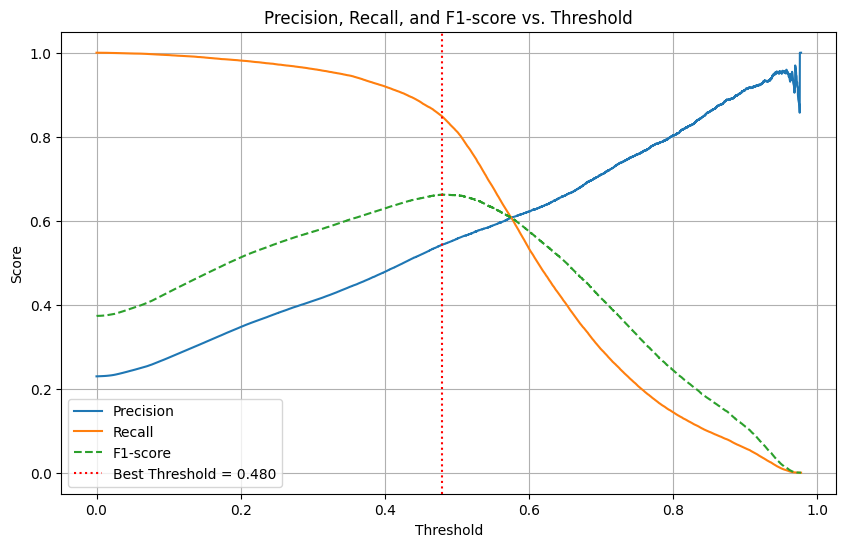

In [12]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Dự đoán xác suất cho lớp 1
y_scores = best_model.predict_proba(X_test_selected)[:, 1]

# Tính precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Tính F1-score cho từng threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Tìm threshold cho F1-score cao nhất
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold = {best_thresh:.4f}")
print(f"Best F1-score = {best_f1:.4f}")

# Dự đoán với ngưỡng tốt nhất
y_pred_best = (y_scores >= best_thresh).astype(int)
print("\nClassification report at best threshold:")
print(classification_report(y_test, y_pred_best, digits=3))

# Vẽ biểu đồ precision-recall và F1-score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-score', linestyle='--')
plt.axvline(best_thresh, color='red', linestyle=':', label=f'Best Threshold = {best_thresh:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs. Threshold')
plt.legend()
plt.grid()
plt.show()

In [13]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optuna objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 40),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred, average='macro')  # cân bằng cả lớp 0 và 1

# Tối ưu
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)

# Kết quả tốt nhất
print("Best trial:")
print(study.best_trial.params)

# Train lại với best model
best_params = study.best_trial.params
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Dự đoán và đánh giá
y_proba = best_model.predict_proba(X_test)[:, 1]

# Thử thay đổi ngưỡng để cải thiện class 1
from sklearn.metrics import classification_report
for t in [0.55, 0.5, 0.45, 0.4]:
    y_pred = (y_proba >= t).astype(int)
    print(f"\nThreshold {t}")
    print(classification_report(y_test, y_pred, digits=3))

[I 2025-05-03 17:01:52,148] A new study created in memory with name: no-name-454cfb0c-8e7c-42b1-aa1b-7fb6e617637f
[I 2025-05-03 17:04:12,038] Trial 0 finished with value: 0.7587544532680248 and parameters: {'n_estimators': 168, 'max_depth': 18, 'min_samples_leaf': 9, 'min_samples_split': 9, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7587544532680248.
[I 2025-05-03 17:09:06,288] Trial 1 finished with value: 0.7605771850309023 and parameters: {'n_estimators': 124, 'max_depth': 24, 'min_samples_leaf': 8, 'min_samples_split': 8, 'max_features': 0.5, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.7605771850309023.
[I 2025-05-03 17:10:28,387] Trial 2 finished with value: 0.7619738582558594 and parameters: {'n_estimators': 113, 'max_depth': 18, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_features': 'log2', 'class_weight': None}. Best is trial 2 with value: 0.7619738582558594.
[I 2025-05-03 17:19:03,310] Trial 3 finished wit

Best trial:
{'n_estimators': 113, 'max_depth': 18, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_features': 'log2', 'class_weight': None}

Threshold 0.55
              precision    recall  f1-score   support

           0      0.843     0.966     0.900    159566
           1      0.777     0.396     0.525     47528

    accuracy                          0.835    207094
   macro avg      0.810     0.681     0.713    207094
weighted avg      0.828     0.835     0.814    207094


Threshold 0.5
              precision    recall  f1-score   support

           0      0.874     0.938     0.905    159566
           1      0.724     0.544     0.621     47528

    accuracy                          0.848    207094
   macro avg      0.799     0.741     0.763    207094
weighted avg      0.839     0.848     0.840    207094


Threshold 0.45
              precision    recall  f1-score   support

           0      0.902     0.900     0.901    159566
           1      0.667     0.673     0.670   

Best threshold = 0.3997
Best F1-score = 0.6833

Classification report at best threshold:
              precision    recall  f1-score   support

           0      0.927     0.854     0.889    159566
           1      0.613     0.772     0.683     47528

    accuracy                          0.836    207094
   macro avg      0.770     0.813     0.786    207094
weighted avg      0.854     0.836     0.842    207094



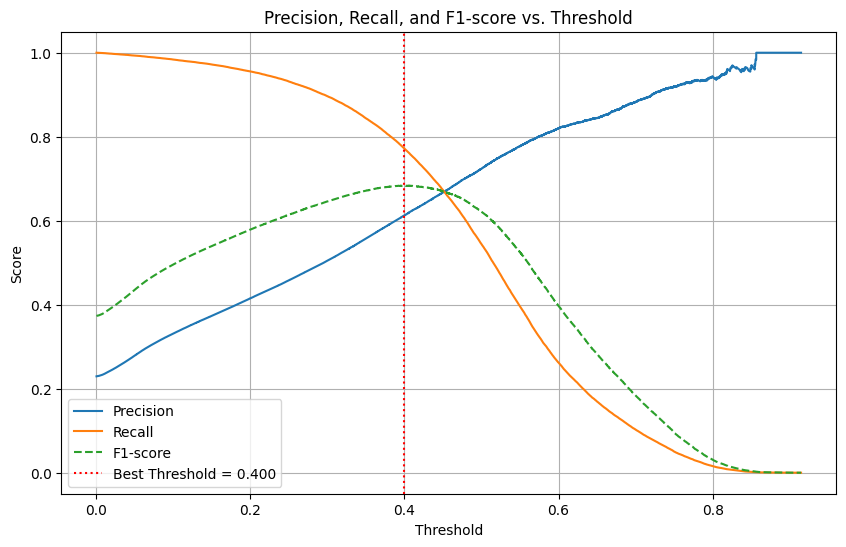

In [14]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Dự đoán xác suất cho lớp 1
y_scores = best_model.predict_proba(X_test)[:, 1]

# Tính precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Tính F1-score cho từng threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Tìm threshold cho F1-score cao nhất
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold = {best_thresh:.4f}")
print(f"Best F1-score = {best_f1:.4f}")

# Dự đoán với ngưỡng tốt nhất
y_pred_best = (y_scores >= best_thresh).astype(int)
print("\nClassification report at best threshold:")
print(classification_report(y_test, y_pred_best, digits=3))

# Vẽ biểu đồ precision-recall và F1-score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-score', linestyle='--')
plt.axvline(best_thresh, color='red', linestyle=':', label=f'Best Threshold = {best_thresh:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs. Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Khoi tao model random forest
model_RFC = RandomForestClassifier(n_estimators=200, random_state=42) 

# Fit vao du lieu train
model_RFC.fit(X_train, y_train)

# Du doan 
y_pred = model_RFC.predict(X_test)

# In ket qua
print_scores(y_test, y_pred)

In [ ]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Khoi tao model random forest
model_RFC = RandomForestClassifier(n_estimators=200, random_state=42) 

# Fit vao du lieu train
model_RFC.fit(X_train_scaled, y_train)

# Du doan 
y_pred = model_RFC.predict(X_test_scaled)

# In ket qua
print_scores( y_test, y_pred)

In [ ]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Khoi tao model random forest
model_RFC = RandomForestClassifier(n_estimators=200, random_state=42) 

# Fit vao du lieu train
model_RFC.fit(X_train_selected, y_train)

# Du doan 
y_pred = model_RFC.predict(X_test_selected)

# In ket qua
print_scores( y_test, y_pred)

=> Chọn đặc trưng hay không kết quả tương tự nhau

In [ ]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Khoi tao model random forest
model_RFC = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced') 

# Fit vao du lieu train
model_RFC.fit(X_train_scaled, y_train)

# Du doan 
y_pred = model_RFC.predict(X_test_scaled)

# In ket qua
print_scores( y_test, y_pred)

In [ ]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Khoi tao model random forest
model_RFC = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample') 

# Fit vao du lieu train
model_RFC.fit(X_train_scaled, y_train)

# Du doan 
y_pred = model_RFC.predict(X_test_scaled)

# In ket qua
print_scores( y_test, y_pred)

=> Thêm class_weight bị giảm mạnh dự đoán lớp 1

**Random Forest**
* Mặc định: Nhận mưa còn yếu nhưng tương đối khá
* Thêm class_weight: Mô hình bias quá nặng về lớp thiểu số, nhận mưa tệ hơn

=> Giải pháp:
1. SMOTE hoặc SMOTEENN
2. Thử threshold tuning

In [ ]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Khoi tao model random forest
model_RFC = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=5,
    class_weight='balanced_subsample',
    random_state=42) 

# Fit vao du lieu train
model_RFC.fit(X_train_scaled, y_train)

# Du doan 
y_pred = model_RFC.predict(X_test_scaled)

# In ket qua
print_scores( y_test, y_pred)

In [9]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optuna objective
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 40),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    return f1_score(y_test, y_pred, average='macro')  # cân bằng cả lớp 0 và 1

# Tối ưu
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)

# Kết quả tốt nhất
print("Best trial:")
print(study.best_trial.params)

# Train lại với best model
best_params = study.best_trial.params
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

# Dự đoán và đánh giá
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Thử thay đổi ngưỡng để cải thiện class 1
from sklearn.metrics import classification_report
for t in [0.5, 0.45, 0.4]:
    y_pred = (y_proba >= t).astype(int)
    print(f"\nThreshold {t}")
    print(classification_report(y_test, y_pred, digits=3))

[I 2025-05-03 16:04:09,618] A new study created in memory with name: no-name-ebb0bdce-7427-4029-b481-7445775c6198
[I 2025-05-03 16:06:42,144] Trial 0 finished with value: 0.7762628799356563 and parameters: {'n_estimators': 178, 'max_depth': 37, 'min_samples_leaf': 8, 'min_samples_split': 7, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7762628799356563.
[I 2025-05-03 16:08:19,419] Trial 1 finished with value: 0.75028518832003 and parameters: {'n_estimators': 169, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 3, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 0 with value: 0.7762628799356563.
[I 2025-05-03 16:11:14,156] Trial 2 finished with value: 0.7677764252915582 and parameters: {'n_estimators': 263, 'max_depth': 16, 'min_samples_leaf': 5, 'min_samples_split': 10, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.7762628799356563.
[I 2025-05-03 16:18:03,690] Trial 3 finished with value: 0.768

Best trial:
{'n_estimators': 178, 'max_depth': 37, 'min_samples_leaf': 8, 'min_samples_split': 7, 'max_features': 'sqrt', 'class_weight': 'balanced'}

Threshold 0.5
              precision    recall  f1-score   support

           0      0.934     0.831     0.880    159566
           1      0.586     0.803     0.677     47528

    accuracy                          0.825    207094
   macro avg      0.760     0.817     0.779    207094
weighted avg      0.854     0.825     0.833    207094


Threshold 0.45
              precision    recall  f1-score   support

           0      0.951     0.787     0.861    159566
           1      0.547     0.863     0.669     47528

    accuracy                          0.804    207094
   macro avg      0.749     0.825     0.765    207094
weighted avg      0.858     0.804     0.817    207094


Threshold 0.4
              precision    recall  f1-score   support

           0      0.962     0.738     0.835    159566
           1      0.507     0.903     0.6

Best threshold = 0.5082
Best F1-score = 0.6779

Classification report at best threshold:
              precision    recall  f1-score   support

           0      0.931     0.838     0.882    159566
           1      0.593     0.792     0.678     47528

    accuracy                          0.827    207094
   macro avg      0.762     0.815     0.780    207094
weighted avg      0.853     0.827     0.835    207094



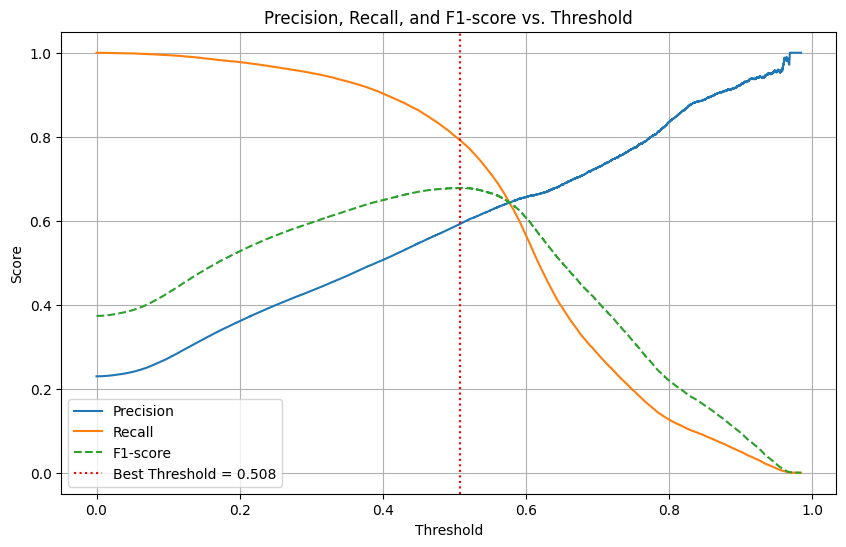

In [10]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Dự đoán xác suất cho lớp 1
y_scores = best_model.predict_proba(X_test_scaled)[:, 1]

# Tính precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Tính F1-score cho từng threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Tìm threshold cho F1-score cao nhất
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold = {best_thresh:.4f}")
print(f"Best F1-score = {best_f1:.4f}")

# Dự đoán với ngưỡng tốt nhất
y_pred_best = (y_scores >= best_thresh).astype(int)
print("\nClassification report at best threshold:")
print(classification_report(y_test, y_pred_best, digits=3))

# Vẽ biểu đồ precision-recall và F1-score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1-score', linestyle='--')
plt.axvline(best_thresh, color='red', linestyle=':', label=f'Best Threshold = {best_thresh:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs. Threshold')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Khoi tao model random forest
model_RFC = RandomForestClassifier(
    n_estimators=400, #Tăng số lượng cây
    max_depth=15,
    min_samples_leaf=3,
    min_samples_split=9, 
    max_features='log2',
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
) 

# Fit vao du lieu train
model_RFC.fit(X_train_scaled, y_train)

y_pred = model_RFC.predict(X_test_scaled)

print_scores( y_test, y_pred)

y_probs = model_RFC.predict_proba(X_test_scaled)[:,1]

best_thresh = 0.0
best_f1 = 0.0
for t in np.arange(0.1, 0.9, 0.05):
    y_pred = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh}, F1: {best_f1}")

In [ ]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier

THRESHOLD = 0.55
# Khoi tao model random forest
model_RFC = RandomForestClassifier(
    n_estimators=400,
    max_depth=15,
    min_samples_leaf=3,
    min_samples_split=9, 
    max_features='log2',
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
) 

# Fit vao du lieu train
model_RFC.fit(X_train_scaled, y_train)

y_pred = model_RFC.predict(X_test_scaled)

print_scores( y_test, y_pred)

y_probs = model_RFC.predict_proba(X_test_scaled)[:,1]
y_pred_thresh = (y_probs >= THRESHOLD).astype(int)

# In kết quả
from sklearn.metrics import classification_report
print("\nClassification report with threshold = 0.55:")
print(classification_report(y_test, y_pred_thresh))

In [ ]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier

# Khoi tao model random forest
model_RFC = RandomForestClassifier(
    n_estimators=272,
    max_depth=15,
    min_samples_leaf=3,
    min_samples_split=9, 
    max_features='log2',
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
) 

# Fit vao du lieu train
model_RFC.fit(X_train_scaled, y_train)

y_pred = model_RFC.predict(X_test_scaled)

print_scores( y_test, y_pred)

y_probs = model_RFC.predict_proba(X_test_scaled)[:,1]

best_thresh = 0.0
best_f1 = 0.0
for t in np.arange(0.1, 0.9, 0.05):
    y_pred = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh}, F1: {best_f1}")

| Cấu hình              | Accuracy | F1(0) | F1(1) | Chênh lệch F1              |
| --------------------- | -------- | ----- | ----- | -------------------------- |
| 272, no threshold     | 0.78     | 0.84  | 0.65  | 0.19                       |
| 400, no threshold     | 0.78     | 0.84  | 0.65  | 0.19                       |
| 400, threshold = 0.55 | 0.80     | 0.86  | 0.65  | 0.21 (chênh lệch tăng nhẹ) |

=> Tăng n_estimators kết quả vẫn thế.

# 6. Cân bằng dữ liệu (oversampling)

## 6.1 SMOTE

RandomizedSearchCV chạy lâu.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, 25],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'class_weight': ['balanced_subsample']
}

rf = RandomForestClassifier(random_state=42)

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_scaled, y_smenn)

best_model = search.best_estimator_
print("Best parameters found:", search.best_params_)


# Dự đoán xác suất
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Thử các ngưỡng khác nhau
thresholds = [0.3, 0.4, 0.5]
for thresh in thresholds:
    y_pred_thresh = (y_proba > thresh).astype(int)
    print(f"\nThreshold: {thresh}")
    print(classification_report(y_test, y_pred_thresh, digits=3))

optuna chạy hơi lâu. Random Forest smote xong optuna kết quả thấp, không bằng kết quả khi chưa smote và tuning.

In [ ]:
import optuna
# SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Hàm objective cho Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced_subsample']),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train_scaled, y_sm)
    y_pred = model.predict(X_test_scaled)
    return f1_score(y_test, y_pred)

# Tối ưu
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)  # 30 trials hoặc 10 phút

print("Best trial:")
print(study.best_trial.params)

In [ ]:
best_params = study.best_trial.params
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train_scaled, y_sm)

y_pred = best_model.predict(X_test_scaled)

print_scores( y_test, y_pred)

# 7. Kết luận

Mô hình tốt nhất là Random Forest đã scale, không upsampling, threshold=0.55 và bộ tham số đã chọn từ optuna.